In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def generate_radiosonde_dummy_data(
    model_name,
    start_height_m=0,
    end_height_m=20000, # Typical radiosonde ascent to 20 km
    step_m=100,         # Data points every 100 meters
    base_temp_c=25,     # Surface temperature
    base_pressure_hpa=1013.25, # Surface pressure
    base_rh_percent=80  # Surface RH
):
    """
    Generates dummy radiosonde data for a single model, simulating realistic trends.

    Args:
        model_name (str): Name of the radiosonde model (e.g., 'Vaisala RS41-SG').
        start_height_m (int): Starting height in meters.
        end_height_m (int): Ending height in meters.
        step_m (int): Height interval for data points.
        base_temp_c (float): Base temperature at start_height_m.
        base_pressure_hpa (float): Base pressure at start_height_m.
        base_rh_percent (float): Base relative humidity at start_height_m.

    Returns:
        pd.DataFrame: DataFrame containing 'Height', 'Temperature', 'Relative Humidity',
                      'Pressure', 'Wind Speed', 'Wind Direction' columns.
    """
    heights = np.arange(start_height_m, end_height_m + step_m, step_m)
    num_points = len(heights)

    # Add some model-specific "bias" or "noise signature"
    temp_bias = np.random.normal(0, 0.5) if "Vaisala" in model_name else np.random.normal(0, 0.8)
    rh_bias = np.random.normal(0, 2) if "Vaisala" in model_name else np.random.normal(0, 3)
    pressure_noise_factor = 1.0001 if "Vaisala" in model_name else 1.0002
    wind_speed_bias = np.random.normal(0, 0.5) if "Vaisala" in model_name else np.random.normal(0, 1)
    wind_dir_noise = np.random.normal(0, 5) if "Vaisala" in model_name else np.random.normal(0, 8)

    # 1. Temperature (Celsius) - Decreases with height (lapse rate)
    # Average tropospheric lapse rate ~6.5 C/km = 0.0065 C/m
    temperatures = base_temp_c - (heights * 0.0065) + np.random.normal(0, 1.0, num_points) + temp_bias
    # Introduce an inversion layer for realism (e.g., at 1000-1500m)
    inversion_start_h = 1000
    inversion_end_h = 1500
    if start_height_m <= inversion_end_h:
        inversion_mask = (heights >= inversion_start_h) & (heights <= inversion_end_h)
        inversion_effect = np.linspace(0, 5, sum(inversion_mask)) # Temp increases by 5C
        temperatures[inversion_mask] += inversion_effect[:sum(inversion_mask)]

    # 2. Relative Humidity (%) - Varies, can show dry/moist layers
    relative_humidities = np.clip(
        base_rh_percent - (heights / 200) + 10 * np.sin(heights / 1000) + np.random.normal(0, 5, num_points) + rh_bias,
        0, 100
    )
    # Simulate a very dry layer higher up (e.g., tropopause region)
    dry_layer_start_h = 10000
    dry_layer_end_h = 12000
    if end_height_m >= dry_layer_start_h:
        dry_layer_mask = (heights >= dry_layer_start_h) & (heights <= dry_layer_end_h)
        relative_humidities[dry_layer_mask] = np.clip(relative_humidities[dry_layer_mask] * 0.2, 5, 30)

    # 3. Pressure (hPa) - Exponential decrease with height
    # P = P0 * exp(-h/scale_height)
    # Scale height for atmosphere approx 8 km = 8000 m
    pressures = base_pressure_hpa * np.exp(-heights / 8000) * (1 + np.random.normal(0, 0.0005, num_points) * pressure_noise_factor)
    pressures = np.clip(pressures, 0.1, base_pressure_hpa) # Ensure pressure stays positive

    # 4. Wind Speed (m/s) - Varies, often increases with height, then decreases near tropopause
    wind_speeds = (20 * np.sin(heights / 3000)**2 + 5) + np.random.normal(0, 2, num_points) + wind_speed_bias
    # Simulate a jet stream (e.g., around 10-12 km)
    jet_stream_start_h = 10000
    jet_stream_end_h = 12000
    if end_height_m >= jet_stream_start_h:
        jet_mask = (heights >= jet_stream_start_h) & (heights <= jet_stream_end_h)
        wind_speeds[jet_mask] += 20 * np.sin(np.linspace(0, np.pi, sum(jet_mask))) # Add a peak
    wind_speeds = np.clip(wind_speeds, 0, 80) # Speeds typically don't exceed this

    # 5. Wind Direction (degrees) - Varies with height (wind shear)
    wind_directions = (180 + 90 * np.sin(heights / 4000) + 45 * np.cos(heights / 2000) + np.random.normal(0, 10, num_points) + wind_dir_noise) % 360
    wind_directions = np.clip(wind_directions, 0, 360) # Keep between 0 and 360

    data = {
        'Height (m)': heights,
        'Temperature (C)': temperatures,
        'Relative Humidity (%)': relative_humidities,
        'Pressure (hPa)': pressures,
        'Wind Speed (m/s)': wind_speeds,
        'Wind Direction (deg)': wind_directions
    }
    return pd.DataFrame(data)

def plot_radiosonde_data(df_vaisala, df_azista):
    """
    Plots radiosonde data from two different models on a grid of subplots.

    Args:
        df_vaisala (pd.DataFrame): DataFrame for Vaisala sensor data.
        df_azista (pd.DataFrame): DataFrame for Azista sensor data.
    """
    variables = {
        'Temperature (C)': {'ylabel': 'Temperature (°C)', 'color_vaisala': 'tab:red', 'color_azista': 'tab:blue'},
        'Relative Humidity (%)': {'ylabel': 'Relative Humidity (%)', 'color_vaisala': 'tab:green', 'color_azista': 'tab:purple'},
        'Pressure (hPa)': {'ylabel': 'Pressure (hPa)', 'color_vaisala': 'tab:orange', 'color_azista': 'tab:cyan'},
        'Wind Speed (m/s)': {'ylabel': 'Wind Speed (m/s)', 'color_vaisala': 'tab:brown', 'color_azista': 'tab:pink'},
        'Wind Direction (deg)': {'ylabel': 'Wind Direction (°)', 'color_vaisala': 'tab:olive', 'color_azista': 'tab:gray'}
    }

    # Create a 3x2 grid for 5 plots, the last one will be empty or for notes
    fig, axs = plt.subplots(3, 2, figsize=(14, 18), sharey='row') # Share Y-axis (Height) across rows

    # Flatten axs for easy iteration
    axs = axs.flatten()

    for i, (col_name, plot_info) in enumerate(variables.items()):
        ax = axs[i]
        
        # Plot Vaisala data
        ax.plot(df_vaisala[col_name], df_vaisala['Height (m)'],
                label='Vaisala RS41-SG', color=plot_info['color_vaisala'], linewidth=2)
        
        # Plot Azista data
        ax.plot(df_azista[col_name], df_azista['Height (m)'],
                label='Azista ATMS-3710', color=plot_info['color_azista'], linestyle='--', linewidth=2)
        
        ax.set_title(col_name)
        ax.set_xlabel(plot_info['ylabel'])
        ax.grid(True, linestyle=':', alpha=0.7)
        ax.legend(loc='lower left', fontsize='small') # Place legend inside plot

        # For pressure, use a log scale for better visualization over large height ranges
        if col_name == 'Pressure (hPa)':
            ax.set_xscale('log')
            # Adjust x-axis ticks for log scale if needed
            # ax.set_xticks([1000, 500, 200, 100, 50, 20, 10, 5, 2, 1])
            # ax.set_xticklabels([1000, 500, 200, 100, 50, 20, 10, 5, 2, 1])
            ax.invert_xaxis() # Pressure decreases as you go right on standard plots

    # Set Y-axis label for the left-most plots in each row
    axs[0].set_ylabel('Height (m)', fontsize=12)
    axs[2].set_ylabel('Height (m)', fontsize=12)
    axs[4].set_ylabel('Height (m)', fontsize=12)

    # Remove the extra (6th) subplot if it's not needed
    if len(variables) < len(axs):
        fig.delaxes(axs[len(variables)])

    plt.suptitle('Radiosonde Measured Parameters vs. Height (Two Sensor Models)', fontsize=16, y=1.02)
    plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout to prevent suptitle overlap
    plt.show()

if __name__ == "__main__":
    print("Generating dummy radiosonde data...")

    # Generate dummy data for Vaisala sensor
    vaisala_data = generate_radiosonde_dummy_data(
        model_name='Vaisala RS41-SG',
        base_temp_c=25.2,
        base_pressure_hpa=1012.8,
        base_rh_percent=78
    )

    # Generate dummy data for Azista sensor (with slightly different characteristics)
    azista_data = generate_radiosonde_dummy_data(
        model_name='Azista ATMS-3710',
        base_temp_c=24.8,
        base_pressure_hpa=1013.5,
        base_rh_percent=82,
        random_variation_factor=0.08 # Slightly more noisy for Azista example
    )

    print("Plotting radiosonde data...")
    plot_radiosonde_data(vaisala_data, azista_data)
    print("Plotting complete.")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def generate_radiosonde_dummy_data(
    model_name,
    start_height_m=0,
    end_height_m=20000, # Typical radiosonde ascent to 20 km
    step_m=100,         # Data points every 100 meters
    base_temp_c=25,     # Surface temperature
    base_pressure_hpa=1013.25, # Surface pressure
    base_rh_percent=80,  # Surface RH
    random_noise_scale=1.0 # <--- ADDED THIS NEW PARAMETER
):
    """
    Generates dummy radiosonde data for a single model, simulating realistic trends.

    Args:
        model_name (str): Name of the radiosonde model (e.g., 'Vaisala RS41-SG').
        start_height_m (int): Starting height in meters.
        end_height_m (int): Ending height in meters.
        step_m (int): Height interval for data points.
        base_temp_c (float): Base temperature at start_height_m.
        base_pressure_hpa (float): Base pressure at start_height_m.
        base_rh_percent (float): Base relative humidity at start_height_m.
        random_noise_scale (float): Multiplier for the random noise added to data.
                                    Higher value means more randomness/variation.

    Returns:
        pd.DataFrame: DataFrame containing 'Height', 'Temperature', 'Relative Humidity',
                      'Pressure', 'Wind Speed', 'Wind Direction' columns.
    """
    heights = np.arange(start_height_m, end_height_m + step_m, step_m)
    num_points = len(heights)

    # Add some model-specific "bias" or "noise signature"
    # These base noise levels are now multiplied by random_noise_scale
    temp_noise_base = 1.0 * random_noise_scale
    rh_noise_base = 5.0 * random_noise_scale
    pressure_noise_base = 0.0005 * random_noise_scale
    wind_speed_noise_base = 2.0 * random_noise_scale
    wind_dir_noise_base = 10.0 * random_noise_scale

    temp_bias = np.random.normal(0, 0.5 * random_noise_scale) if "Vaisala" in model_name else np.random.normal(0, 0.8 * random_noise_scale)
    rh_bias = np.random.normal(0, 2 * random_noise_scale) if "Vaisala" in model_name else np.random.normal(0, 3 * random_noise_scale)
    pressure_noise_factor = 1.0001 if "Vaisala" in model_name else 1.0002 # This is already a factor, less tied to random_noise_scale directly
    wind_speed_bias = np.random.normal(0, 0.5 * random_noise_scale) if "Vaisala" in model_name else np.random.normal(0, 1 * random_noise_scale)
    wind_dir_noise_specific = np.random.normal(0, 5 * random_noise_scale) if "Vaisala" in model_name else np.random.normal(0, 8 * random_noise_scale)


    # 1. Temperature (Celsius) - Decreases with height (lapse rate)
    # Average tropospheric lapse rate ~6.5 C/km = 0.0065 C/m
    temperatures = base_temp_c - (heights * 0.0065) + np.random.normal(0, temp_noise_base, num_points) + temp_bias
    # Introduce an inversion layer for realism (e.g., at 1000-1500m)
    inversion_start_h = 1000
    inversion_end_h = 1500
    if start_height_m <= inversion_end_h:
        inversion_mask = (heights >= inversion_start_h) & (heights <= inversion_end_h)
        # Ensure inversion_effect matches the size of the masked segment
        if np.any(inversion_mask):
            inversion_effect = np.linspace(0, 5, np.sum(inversion_mask)) # Temp increases by 5C
            temperatures[inversion_mask] += inversion_effect

    # 2. Relative Humidity (%) - Varies, can show dry/moist layers
    relative_humidities = np.clip(
        base_rh_percent - (heights / 200) + 10 * np.sin(heights / 1000) + np.random.normal(0, rh_noise_base, num_points) + rh_bias,
        0, 100
    )
    # Simulate a very dry layer higher up (e.g., tropopause region)
    dry_layer_start_h = 10000
    dry_layer_end_h = 12000
    if end_height_m >= dry_layer_start_h:
        dry_layer_mask = (heights >= dry_layer_start_h) & (heights <= dry_layer_end_h)
        if np.any(dry_layer_mask):
            relative_humidities[dry_layer_mask] = np.clip(relative_humidities[dry_layer_mask] * 0.2, 5, 30)

    # 3. Pressure (hPa) - Exponential decrease with height
    # P = P0 * exp(-h/scale_height)
    # Scale height for atmosphere approx 8 km = 8000 m
    pressures = base_pressure_hpa * np.exp(-heights / 8000) * (1 + np.random.normal(0, pressure_noise_base, num_points) * pressure_noise_factor)
    pressures = np.clip(pressures, 0.1, base_pressure_hpa) # Ensure pressure stays positive

    # 4. Wind Speed (m/s) - Varies, often increases with height, then decreases near tropopause
    wind_speeds = (20 * np.sin(heights / 3000)**2 + 5) + np.random.normal(0, wind_speed_noise_base, num_points) + wind_speed_bias
    # Simulate a jet stream (e.g., around 10-12 km)
    jet_stream_start_h = 10000
    jet_stream_end_h = 12000
    if end_height_m >= jet_stream_start_h:
        jet_mask = (heights >= jet_stream_start_h) & (heights <= jet_stream_end_h)
        if np.any(jet_mask):
            wind_speeds[jet_mask] += 20 * np.sin(np.linspace(0, np.pi, np.sum(jet_mask))) # Add a peak
    wind_speeds = np.clip(wind_speeds, 0, 80) # Speeds typically don't exceed this

    # 5. Wind Direction (degrees) - Varies with height (wind shear)
    wind_directions = (180 + 90 * np.sin(heights / 4000) + 45 * np.cos(heights / 2000) + np.random.normal(0, wind_dir_noise_base, num_points) + wind_dir_noise_specific) % 360
    wind_directions = np.clip(wind_directions, 0, 360) # Keep between 0 and 360

    data = {
        'Height (m)': heights,
        'Temperature (C)': temperatures,
        'Relative Humidity (%)': relative_humidities,
        'Pressure (hPa)': pressures,
        'Wind Speed (m/s)': wind_speeds,
        'Wind Direction (deg)': wind_directions
    }
    return pd.DataFrame(data)

def plot_radiosonde_data(df_vaisala, df_azista):
    """
    Plots radiosonde data from two different models on a grid of subplots.

    Args:
        df_vaisala (pd.DataFrame): DataFrame for Vaisala sensor data.
        df_azista (pd.DataFrame): DataFrame for Azista sensor data.
    """
    variables = {
        'Temperature (C)': {'ylabel': 'Temperature (°C)', 'color_vaisala': 'tab:red', 'color_azista': 'tab:blue'},
        'Relative Humidity (%)': {'ylabel': 'Relative Humidity (%)', 'color_vaisala': 'tab:green', 'color_azista': 'tab:purple'},
        'Pressure (hPa)': {'ylabel': 'Pressure (hPa)', 'color_vaisala': 'tab:orange', 'color_azista': 'tab:cyan'},
        'Wind Speed (m/s)': {'ylabel': 'Wind Speed (m/s)', 'color_vaisala': 'tab:brown', 'color_azista': 'tab:pink'},
        'Wind Direction (deg)': {'ylabel': 'Wind Direction (°)', 'color_vaisala': 'tab:olive', 'color_azista': 'tab:gray'}
    }

    # Create a 3x2 grid for 5 plots, the last one will be empty or for notes
    fig, axs = plt.subplots(3, 2, figsize=(14, 18), sharey='row') # Share Y-axis (Height) across rows

    # Flatten axs for easy iteration
    axs = axs.flatten()

    for i, (col_name, plot_info) in enumerate(variables.items()):
        ax = axs[i]
        
        # Plot Vaisala data
        ax.plot(df_vaisala[col_name], df_vaisala['Height (m)'],
                label='Vaisala RS41-SG', color=plot_info['color_vaisala'], linewidth=2)
        
        # Plot Azista data
        ax.plot(df_azista[col_name], df_azista['Height (m)'],
                label='Azista ATMS-3710', color=plot_info['color_azista'], linestyle='--', linewidth=2)
        
        ax.set_title(col_name)
        ax.set_xlabel(plot_info['ylabel'])
        ax.grid(True, linestyle=':', alpha=0.7)
        ax.legend(loc='lower left', fontsize='small') # Place legend inside plot

        # For pressure, use a log scale for better visualization over large height ranges
        if col_name == 'Pressure (hPa)':
            ax.set_xscale('log')
            # Adjust x-axis ticks for log scale if needed
            # ax.set_xticks([1000, 500, 200, 100, 50, 20, 10, 5, 2, 1])
            # ax.set_xticklabels([1000, 500, 200, 100, 50, 20, 10, 5, 2, 1])
            ax.invert_xaxis() # Pressure decreases as you go right on standard plots

    # Set Y-axis label for the left-most plots in each row
    axs[0].set_ylabel('Height (m)', fontsize=12)
    axs[2].set_ylabel('Height (m)', fontsize=12)
    axs[4].set_ylabel('Height (m)', fontsize=12)

    # Remove the extra (6th) subplot if it's not needed
    if len(variables) < len(axs):
        fig.delaxes(axs[len(variables)])

    plt.suptitle('Radiosonde Measured Parameters vs. Height (Two Sensor Models)', fontsize=16, y=1.02)
    plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout to prevent suptitle overlap
    plt.show()

if __name__ == "__main__":
    print("Generating dummy radiosonde data...")

    # Generate dummy data for Vaisala sensor
    vaisala_data = generate_radiosonde_dummy_data(
        model_name='Vaisala RS41-SG',
        base_temp_c=25.2,
        base_pressure_hpa=1012.8,
        base_rh_percent=78,
        random_noise_scale=1.0 # Default noise scale
    )

    # Generate dummy data for Azista sensor (with slightly different characteristics)
    azista_data = generate_radiosonde_dummy_data(
        model_name='Azista ATMS-3710',
        base_temp_c=24.8,
        base_pressure_hpa=1013.5,
        base_rh_percent=82,
        random_noise_scale=1.2 # Slightly more noisy for Azista example
    )

    print("Plotting radiosonde data...")
    plot_radiosonde_data(vaisala_data, azista_data)
    print("Plotting complete.")

Generating dummy radiosonde data...
Plotting radiosonde data...


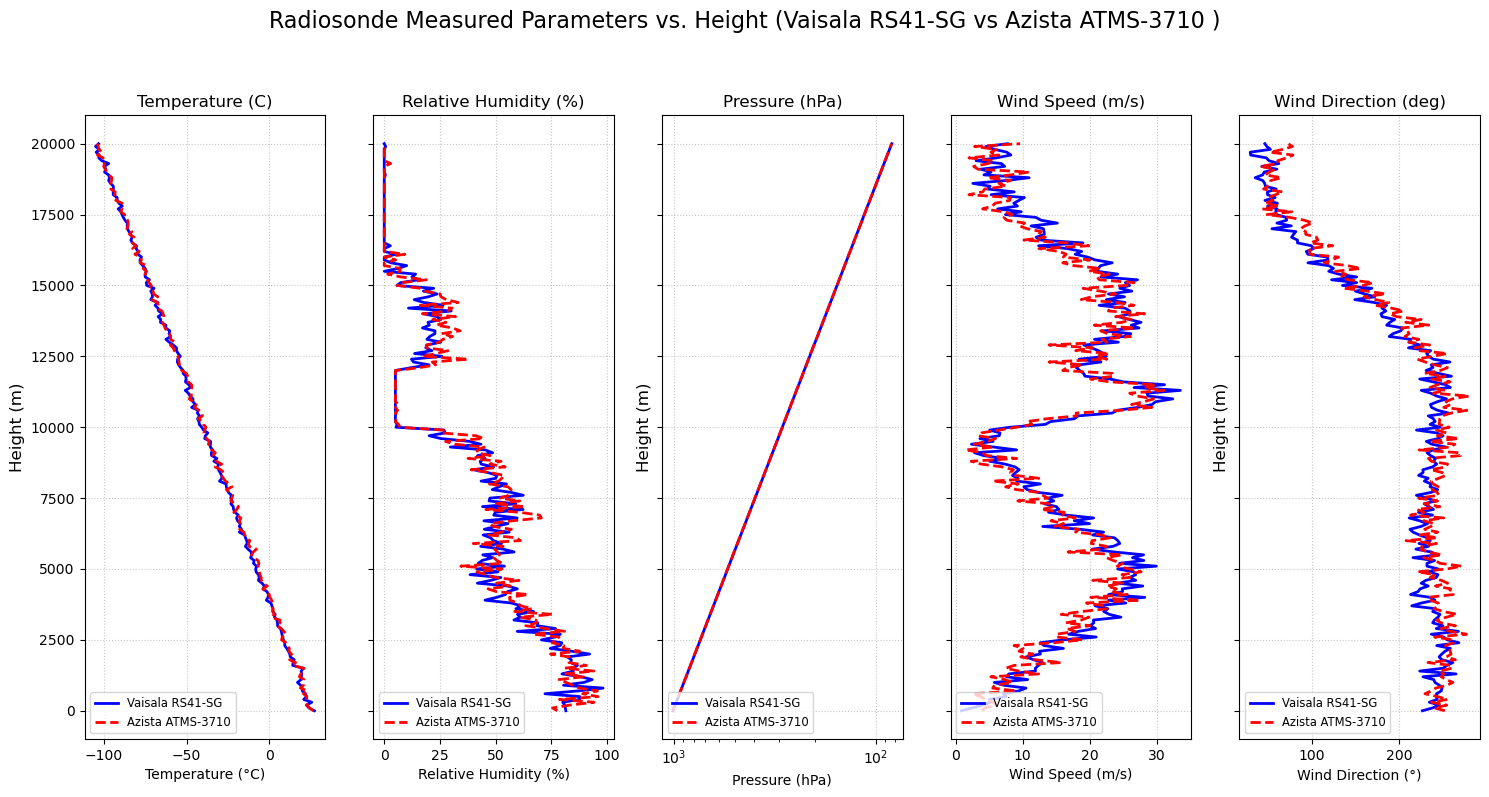

Plotting complete.


In [2]:
## Scrap this Code Just Dummy Data Plot

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def generate_radiosonde_dummy_data(
    model_name,
    start_height_m=0,
    end_height_m=20000, # Typical radiosonde ascent to 20 km
    step_m=100,         # Data points every 100 meters
    base_temp_c=25,     # Surface temperature
    base_pressure_hpa=1013.25, # Surface pressure
    base_rh_percent=80,  # Surface RH
    random_noise_scale=1.0 # Multiplier for the random noise added to data.
):
    """
    Generates dummy radiosonde data for a single model, simulating realistic trends.

    Args:
        model_name (str): Name of the radiosonde model (e.g., 'Vaisala RS41-SG').
        start_height_m (int): Starting height in meters.
        end_height_m (int): Ending height in meters.
        step_m (int): Height interval for data points.
        base_temp_c (float): Base temperature at start_height_m.
        base_pressure_hpa (float): Base pressure at start_height_m.
        base_rh_percent (float): Base relative humidity at start_height_m.
        random_noise_scale (float): Multiplier for the random noise added to data.
                                    Higher value means more randomness/variation.

    Returns:
        pd.DataFrame: DataFrame containing 'Height', 'Temperature', 'Relative Humidity',
                      'Pressure', 'Wind Speed', 'Wind Direction' columns.
    """
    heights = np.arange(start_height_m, end_height_m + step_m, step_m)
    num_points = len(heights)

    # Base noise levels, scaled by random_noise_scale
    temp_noise_base = 1.0 * random_noise_scale
    rh_noise_base = 5.0 * random_noise_scale
    pressure_noise_base = 0.0005 * random_noise_scale
    wind_speed_noise_base = 2.0 * random_noise_scale
    wind_dir_noise_base = 10.0 * random_noise_scale

    # Model-specific biases/noise for more distinct data
    temp_bias = np.random.normal(0, 0.5 * random_noise_scale) if "Vaisala" in model_name else np.random.normal(0, 0.8 * random_noise_scale)
    rh_bias = np.random.normal(0, 2 * random_noise_scale) if "Vaisala" in model_name else np.random.normal(0, 3 * random_noise_scale)
    pressure_noise_factor_model = 1.0001 if "Vaisala" in model_name else 1.0002
    wind_speed_bias = np.random.normal(0, 0.5 * random_noise_scale) if "Vaisala" in model_name else np.random.normal(0, 1 * random_noise_scale)
    wind_dir_noise_specific = np.random.normal(0, 5 * random_noise_scale) if "Vaisala" in model_name else np.random.normal(0, 8 * random_noise_scale)


    # 1. Temperature (Celsius) - Decreases with height (lapse rate)
    temperatures = base_temp_c - (heights * 0.0065) + np.random.normal(0, temp_noise_base, num_points) + temp_bias
    inversion_start_h = 1000
    inversion_end_h = 1500
    if start_height_m <= inversion_end_h:
        inversion_mask = (heights >= inversion_start_h) & (heights <= inversion_end_h)
        if np.any(inversion_mask):
            inversion_effect = np.linspace(0, 5, np.sum(inversion_mask))
            temperatures[inversion_mask] += inversion_effect

    # 2. Relative Humidity (%)
    relative_humidities = np.clip(
        base_rh_percent - (heights / 200) + 10 * np.sin(heights / 1000) + np.random.normal(0, rh_noise_base, num_points) + rh_bias,
        0, 100
    )
    dry_layer_start_h = 10000
    dry_layer_end_h = 12000
    if end_height_m >= dry_layer_start_h:
        dry_layer_mask = (heights >= dry_layer_start_h) & (heights <= dry_layer_end_h)
        if np.any(dry_layer_mask):
            relative_humidities[dry_layer_mask] = np.clip(relative_humidities[dry_layer_mask] * 0.2, 5, 30)

    # 3. Pressure (hPa)
    pressures = base_pressure_hpa * np.exp(-heights / 8000) * (1 + np.random.normal(0, pressure_noise_base, num_points) * pressure_noise_factor_model)
    pressures = np.clip(pressures, 0.1, base_pressure_hpa)

    # 4. Wind Speed (m/s)
    wind_speeds = (20 * np.sin(heights / 3000)**2 + 5) + np.random.normal(0, wind_speed_noise_base, num_points) + wind_speed_bias
    jet_stream_start_h = 10000
    jet_stream_end_h = 12000
    if end_height_m >= jet_stream_start_h:
        jet_mask = (heights >= jet_stream_start_h) & (heights <= jet_stream_end_h)
        if np.any(jet_mask):
            wind_speeds[jet_mask] += 20 * np.sin(np.linspace(0, np.pi, np.sum(jet_mask)))
    wind_speeds = np.clip(wind_speeds, 0, 80)

    # 5. Wind Direction (degrees)
    wind_directions = (180 + 90 * np.sin(heights / 4000) + 45 * np.cos(heights / 2000) + np.random.normal(0, wind_dir_noise_base, num_points) + wind_dir_noise_specific) % 360
    wind_directions = np.clip(wind_directions, 0, 360)

    data = {
        'Height (m)': heights,
        'Temperature (C)': temperatures,
        'Relative Humidity (%)': relative_humidities,
        'Pressure (hPa)': pressures,
        'Wind Speed (m/s)': wind_speeds,
        'Wind Direction (deg)': wind_directions
    }
    return pd.DataFrame(data)

def plot_radiosonde_data(df_vaisala, df_azista):
    """
    Plots radiosonde data from two different models on a grid of subplots,
    maintaining uniform colors for each sensor model across all plots.

    Args:
        df_vaisala (pd.DataFrame): DataFrame for Vaisala sensor data.
        df_azista (pd.DataFrame): DataFrame for Azista sensor data.
    """
    # Define uniform colors for each sensor model
    vaisala_color = 'blue'  # A distinct blue
    azista_color = 'red'    # A distinct red
    
    # You can also use 'tab:blue', 'tab:red', etc., from matplotlib's default color cycle
    # vaisala_color = 'tab:blue'
    # azista_color = 'tab:red'

    variables_to_plot = {
        'Temperature (C)': 'Temperature (°C)',
        'Relative Humidity (%)': 'Relative Humidity (%)',
        'Pressure (hPa)': 'Pressure (hPa)',
        'Wind Speed (m/s)': 'Wind Speed (m/s)',
        'Wind Direction (deg)': 'Wind Direction (°)'
    }

    # Create a 3x2 grid for 5 plots
    #fig, axs = plt.subplots(3, 2, figsize=(14, 18), sharey='row') # Original Code
    fig, axs = plt.subplots(1, 5, figsize=(15, 8), sharey='row')   # Comment out this line and un comment the above line

    # Flatten axs for easy iteration
    axs = axs.flatten()

    for i, (col_name, ylabel_text) in enumerate(variables_to_plot.items()):
        ax = axs[i]
        
        # Plot Vaisala data with consistent color
        ax.plot(df_vaisala[col_name], df_vaisala['Height (m)'],
                label='Vaisala RS41-SG', color=vaisala_color, linewidth=2)
        
        # Plot Azista data with consistent color and linestyle
        ax.plot(df_azista[col_name], df_azista['Height (m)'],
                label='Azista ATMS-3710', color=azista_color, linestyle='--', linewidth=2)
        
        ax.set_title(col_name)
        ax.set_xlabel(ylabel_text)
        ax.grid(True, linestyle=':', alpha=0.7)
        ax.legend(loc='lower left', fontsize='small')

        # Pressure plot specific adjustments
        if col_name == 'Pressure (hPa)':
            ax.set_xscale('log')
            ax.invert_xaxis()

    # Set Y-axis label for the left-most plots in each row (due to sharey='row')
    axs[0].set_ylabel('Height (m)', fontsize=12)
    axs[2].set_ylabel('Height (m)', fontsize=12)
    axs[4].set_ylabel('Height (m)', fontsize=12)

    # Remove the extra (6th) subplot
    if len(variables_to_plot) < len(axs):
        fig.delaxes(axs[len(variables_to_plot)])

    plt.suptitle('Radiosonde Measured Parameters vs. Height (Vaisala RS41-SG vs Azista ATMS-3710 )', fontsize=16, y=1.02)
    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()

if __name__ == "__main__":
    print("Generating dummy radiosonde data...")

    # Generate dummy data for Vaisala sensor
    vaisala_data = generate_radiosonde_dummy_data(
        model_name='Vaisala RS41-SG',
        base_temp_c=25.2,
        base_pressure_hpa=1012.8,
        base_rh_percent=78,
        random_noise_scale=1.0 # Default noise scale
    )

    # Generate dummy data for Azista sensor (with slightly different characteristics and noise)
    azista_data = generate_radiosonde_dummy_data(
        model_name='Azista ATMS-3710',
        base_temp_c=24.8,
        base_pressure_hpa=1013.5,
        base_rh_percent=82,
        random_noise_scale=1.2 # Slightly more overall noise for Azista example
    )

    print("Plotting radiosonde data...")
    plot_radiosonde_data(vaisala_data, azista_data)
    print("Plotting complete.")

Generating dummy radiosonde data...
Plotting radiosonde data...


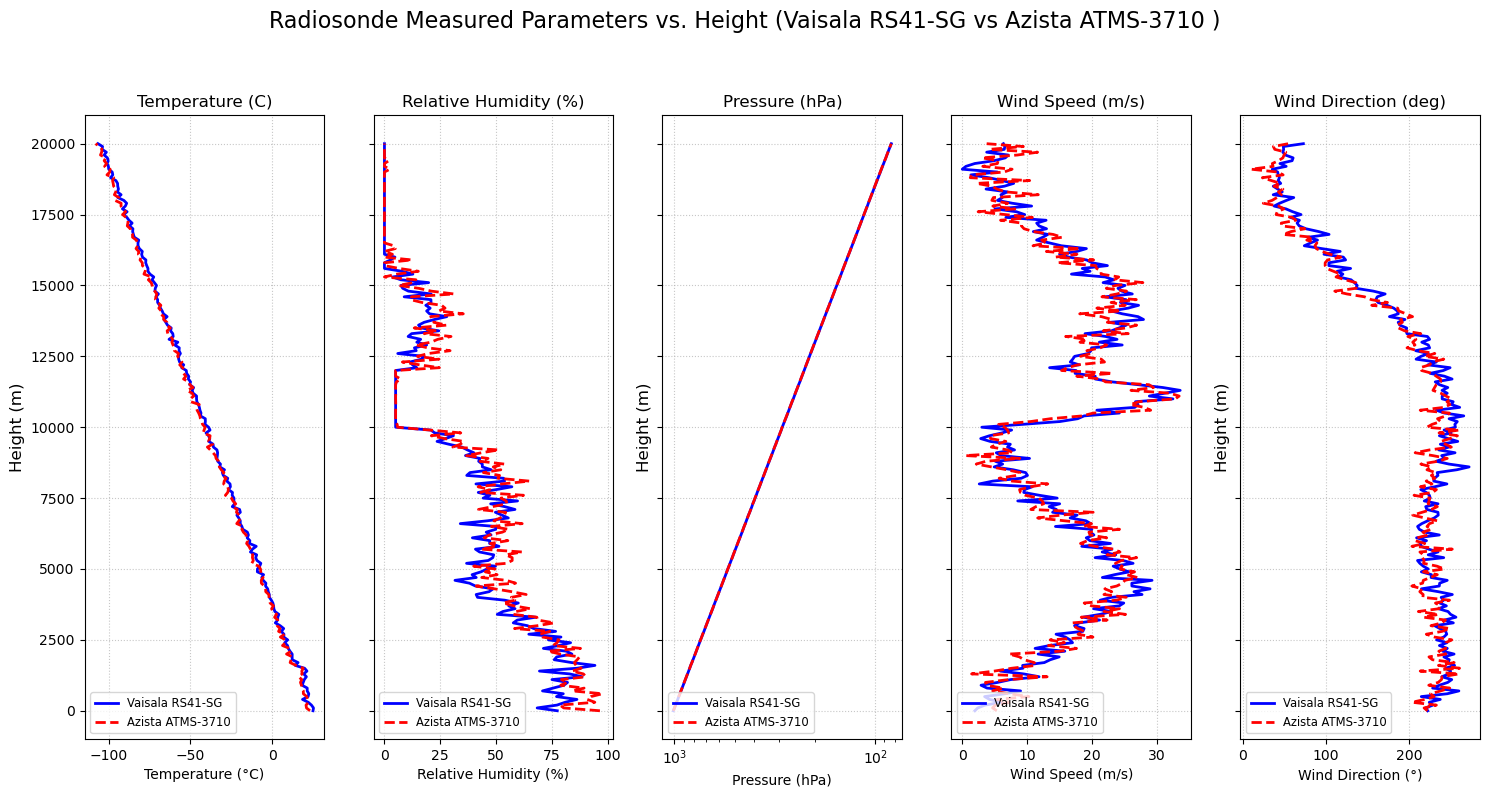

Plotting complete.


In [ ]:
## Refind and Code Refactored for Plotting All Variables in a single plot. 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def generate_radiosonde_dummy_data(
    model_name,
    start_height_m=0,
    end_height_m=20000, # Typical radiosonde ascent to 20 km
    step_m=100,         # Data points every 100 meters
    base_temp_c=25,     # Surface temperature
    base_pressure_hpa=1013.25, # Surface pressure
    base_rh_percent=80,  # Surface RH
    random_noise_scale=1.0 # Multiplier for the random noise added to data.
):
    """
    Generates dummy radiosonde data for a single model, simulating realistic trends.

    Args:
        model_name (str): Name of the radiosonde model (e.g., 'Vaisala RS41-SG').
        start_height_m (int): Starting height in meters.
        end_height_m (int): Ending height in meters.
        step_m (int): Height interval for data points.
        base_temp_c (float): Base temperature at start_height_m.
        base_pressure_hpa (float): Base pressure at start_height_m.
        base_rh_percent (float): Base relative humidity at start_height_m.
        random_noise_scale (float): Multiplier for the random noise added to data.
                                    Higher value means more randomness/variation.

    Returns:
        pd.DataFrame: DataFrame containing 'Height', 'Temperature', 'Relative Humidity',
                      'Pressure', 'Wind Speed', 'Wind Direction' columns.
    """
    heights = np.arange(start_height_m, end_height_m + step_m, step_m)
    num_points = len(heights)

    # Base noise levels, scaled by random_noise_scale
    temp_noise_base = 1.0 * random_noise_scale
    rh_noise_base = 5.0 * random_noise_scale
    pressure_noise_base = 0.0005 * random_noise_scale
    wind_speed_noise_base = 2.0 * random_noise_scale
    wind_dir_noise_base = 10.0 * random_noise_scale

    # Model-specific biases/noise for more distinct data
    temp_bias = np.random.normal(0, 0.5 * random_noise_scale) if "Vaisala" in model_name else np.random.normal(0, 0.8 * random_noise_scale)
    rh_bias = np.random.normal(0, 2 * random_noise_scale) if "Vaisala" in model_name else np.random.normal(0, 3 * random_noise_scale)
    pressure_noise_factor_model = 1.0001 if "Vaisala" in model_name else 1.0002
    wind_speed_bias = np.random.normal(0, 0.5 * random_noise_scale) if "Vaisala" in model_name else np.random.normal(0, 1 * random_noise_scale)
    wind_dir_noise_specific = np.random.normal(0, 5 * random_noise_scale) if "Vaisala" in model_name else np.random.normal(0, 8 * random_noise_scale)


    # 1. Temperature (Celsius) - Decreases with height (lapse rate)
    temperatures = base_temp_c - (heights * 0.0065) + np.random.normal(0, temp_noise_base, num_points) + temp_bias
    inversion_start_h = 1000
    inversion_end_h = 1500
    if start_height_m <= inversion_end_h:
        inversion_mask = (heights >= inversion_start_h) & (heights <= inversion_end_h)
        if np.any(inversion_mask):
            inversion_effect = np.linspace(0, 5, np.sum(inversion_mask))
            temperatures[inversion_mask] += inversion_effect

    # 2. Relative Humidity (%)
    relative_humidities = np.clip(
        base_rh_percent - (heights / 200) + 10 * np.sin(heights / 1000) + np.random.normal(0, rh_noise_base, num_points) + rh_bias,
        0, 100
    )
    dry_layer_start_h = 10000
    dry_layer_end_h = 12000
    if end_height_m >= dry_layer_start_h:
        dry_layer_mask = (heights >= dry_layer_start_h) & (heights <= dry_layer_end_h)
        if np.any(dry_layer_mask):
            relative_humidities[dry_layer_mask] = np.clip(relative_humidities[dry_layer_mask] * 0.2, 5, 30)

    # 3. Pressure (hPa)
    pressures = base_pressure_hpa * np.exp(-heights / 8000) * (1 + np.random.normal(0, pressure_noise_base, num_points) * pressure_noise_factor_model)
    pressures = np.clip(pressures, 0.1, base_pressure_hpa)

    # 4. Wind Speed (m/s)
    wind_speeds = (20 * np.sin(heights / 3000)**2 + 5) + np.random.normal(0, wind_speed_noise_base, num_points) + wind_speed_bias
    jet_stream_start_h = 10000
    jet_stream_end_h = 12000
    if end_height_m >= jet_stream_start_h:
        jet_mask = (heights >= jet_stream_start_h) & (heights <= jet_stream_end_h)
        if np.any(jet_mask):
            wind_speeds[jet_mask] += 20 * np.sin(np.linspace(0, np.pi, np.sum(jet_mask)))
    wind_speeds = np.clip(wind_speeds, 0, 80)

    # 5. Wind Direction (degrees)
    wind_directions = (180 + 90 * np.sin(heights / 4000) + 45 * np.cos(heights / 2000) + np.random.normal(0, wind_dir_noise_base, num_points) + wind_dir_noise_specific) % 360
    wind_directions = np.clip(wind_directions, 0, 360)

    data = {
        'Height (m)': heights,
        'Temperature (C)': temperatures,
        'Relative Humidity (%)': relative_humidities,
        'Pressure (hPa)': pressures,
        'Wind Speed (m/s)': wind_speeds,
        'Wind Direction (deg)': wind_directions
    }
    return pd.DataFrame(data)

def plot_radiosonde_data(df_vaisala, df_azista):
    """
    Plots radiosonde data from two different models on a grid of subplots,
    maintaining uniform colors for each sensor model across all plots.

    Args:
        df_vaisala (pd.DataFrame): DataFrame for Vaisala sensor data.
        df_azista (pd.DataFrame): DataFrame for Azista sensor data.
    """
    # Define uniform colors for each sensor model
    vaisala_color = 'blue'  # A distinct blue
    azista_color = 'red'    # A distinct red
    
    # You can also use 'tab:blue', 'tab:red', etc., from matplotlib's default color cycle
    # vaisala_color = 'tab:blue'
    # azista_color = 'tab:red'

    variables_to_plot = {
        'Temperature (C)': 'Temperature (°C)',
        'Relative Humidity (%)': 'Relative Humidity (%)',
        'Pressure (hPa)': 'Pressure (hPa)',
        'Wind Speed (m/s)': 'Wind Speed (m/s)',
        'Wind Direction (deg)': 'Wind Direction (°)'
    }

    # Create a 3x2 grid for 5 plots
    #fig, axs = plt.subplots(3, 2, figsize=(14, 18), sharey='row') # Original Code
    fig, axs = plt.subplots(1, 5, figsize=(15, 8), sharey='row')   # Comment out this line and un comment the above line

    # Flatten axs for easy iteration
    axs = axs.flatten()

    for i, (col_name, ylabel_text) in enumerate(variables_to_plot.items()):
        ax = axs[i]
        
        # Plot Vaisala data with consistent color
        ax.plot(df_vaisala[col_name], df_vaisala['Height (m)'],
                label='Vaisala RS41-SG', color=vaisala_color, linewidth=2)
        
        # Plot Azista data with consistent color and linestyle
        ax.plot(df_azista[col_name], df_azista['Height (m)'],
                label='Azista ATMS-3710', color=azista_color, linestyle='--', linewidth=2)
        
        ax.set_title(col_name)
        ax.set_xlabel(ylabel_text)
        ax.grid(True, linestyle=':', alpha=0.7)
        ax.legend(loc='lower left', fontsize='small')

        # Pressure plot specific adjustments
        if col_name == 'Pressure (hPa)':
            ax.set_xscale('log')
            ax.invert_xaxis()

    # Set Y-axis label for the left-most plots in each row (due to sharey='row')
    axs[0].set_ylabel('Height (m)', fontsize=12)
    axs[2].set_ylabel('Height (m)', fontsize=12)
    axs[4].set_ylabel('Height (m)', fontsize=12)

    # Remove the extra (6th) subplot
    if len(variables_to_plot) < len(axs):
        fig.delaxes(axs[len(variables_to_plot)])

    plt.suptitle('Radiosonde Measured Parameters vs. Height (Vaisala RS41-SG vs Azista ATMS-3710 )', fontsize=16, y=1.02)
    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()

if __name__ == "__main__":
    print("Generating dummy radiosonde data...")

    # Generate dummy data for Vaisala sensor
    vaisala_data = generate_radiosonde_dummy_data(
        model_name='Vaisala RS41-SG',
        base_temp_c=25.2,
        base_pressure_hpa=1012.8,
        base_rh_percent=78,
        random_noise_scale=1.0 # Default noise scale
    )

    # Generate dummy data for Azista sensor (with slightly different characteristics and noise)
    azista_data = generate_radiosonde_dummy_data(
        model_name='Azista ATMS-3710',
        base_temp_c=24.8,
        base_pressure_hpa=1013.5,
        base_rh_percent=82,
        random_noise_scale=1.2 # Slightly more overall noise for Azista example
    )

    print("Plotting radiosonde data...")
    plot_radiosonde_data(vaisala_data, azista_data)
    print("Plotting complete.")

Vaisala data file not found at: vaisala_data.csv
Azista data file not found at: azista_data.csv

Not all real data loaded. Generating and plotting DUMMY DATA for demonstration.


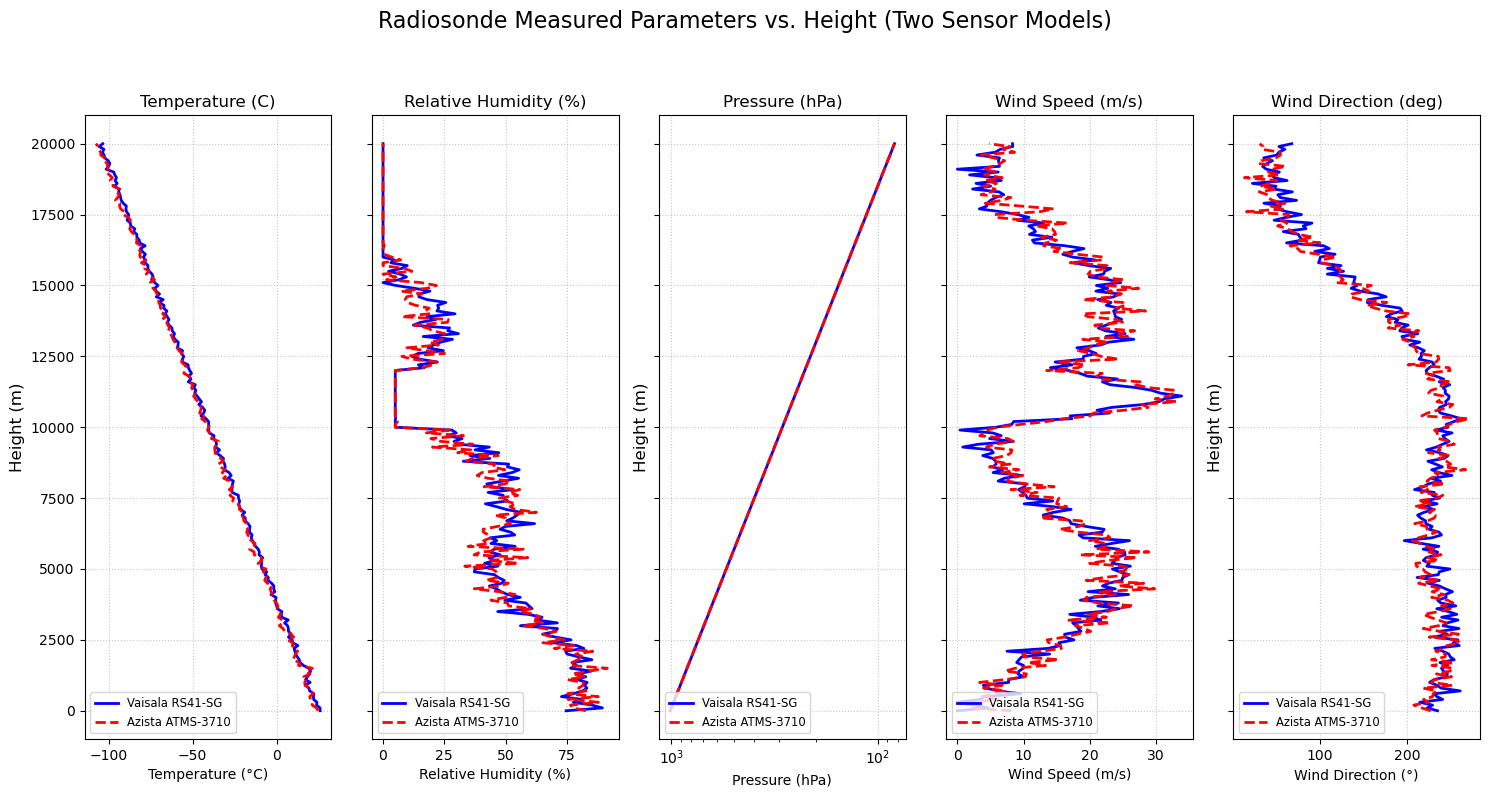

Plotting complete.


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os # For checking if files exist

# --- UTILITY FUNCTION: GENERATE DUMMY DATA (for demonstration/testing if no real data is provided) ---
def generate_radiosonde_dummy_data(
    model_name,
    start_height_m=0,
    end_height_m=20000, # Typical radiosonde ascent to 20 km
    step_m=100,         # Data points every 100 meters
    base_temp_c=25,     # Surface temperature
    base_pressure_hpa=1013.25, # Surface pressure
    base_rh_percent=80,  # Surface RH
    random_noise_scale=1.0 # Multiplier for the random noise added to data.
):
    """
    Generates dummy radiosonde data for a single model, simulating realistic trends.
    This function is primarily for demonstration purposes.

    Args:
        model_name (str): Name of the radiosonde model (e.g., 'Vaisala RS41-SG').
        start_height_m (int): Starting height in meters.
        end_height_m (int): Ending height in meters.
        step_m (int): Height interval for data points.
        base_temp_c (float): Base temperature at start_height_m.
        base_pressure_hpa (float): Base pressure at start_height_m.
        base_rh_percent (float): Base relative humidity at start_height_m.
        random_noise_scale (float): Multiplier for the random noise added to data.
                                    Higher value means more randomness/variation.

    Returns:
        pd.DataFrame: DataFrame containing 'Height', 'Temperature', 'Relative Humidity',
                      'Pressure', 'Wind Speed', 'Wind Direction' columns.
    """
    heights = np.arange(start_height_m, end_height_m + step_m, step_m)
    num_points = len(heights)

    # Base noise levels, scaled by random_noise_scale
    temp_noise_base = 1.0 * random_noise_scale
    rh_noise_base = 5.0 * random_noise_scale
    pressure_noise_base = 0.0005 * random_noise_scale
    wind_speed_noise_base = 2.0 * random_noise_scale
    wind_dir_noise_base = 10.0 * random_noise_scale

    # Model-specific biases/noise for more distinct data
    temp_bias = np.random.normal(0, 0.5 * random_noise_scale) if "Vaisala" in model_name else np.random.normal(0, 0.8 * random_noise_scale)
    rh_bias = np.random.normal(0, 2 * random_noise_scale) if "Vaisala" in model_name else np.random.normal(0, 3 * random_noise_scale)
    pressure_noise_factor_model = 1.0001 if "Vaisala" in model_name else 1.0002
    wind_speed_bias = np.random.normal(0, 0.5 * random_noise_scale) if "Vaisala" in model_name else np.random.normal(0, 1 * random_noise_scale)
    wind_dir_noise_specific = np.random.normal(0, 5 * random_noise_scale) if "Vaisala" in model_name else np.random.normal(0, 8 * random_noise_scale)


    # 1. Temperature (Celsius) - Decreases with height (lapse rate)
    temperatures = base_temp_c - (heights * 0.0065) + np.random.normal(0, temp_noise_base, num_points) + temp_bias
    inversion_start_h = 1000
    inversion_end_h = 1500
    if start_height_m <= inversion_end_h:
        inversion_mask = (heights >= inversion_start_h) & (heights <= inversion_end_h)
        if np.any(inversion_mask):
            inversion_effect = np.linspace(0, 5, np.sum(inversion_mask))
            temperatures[inversion_mask] += inversion_effect

    # 2. Relative Humidity (%)
    relative_humidities = np.clip(
        base_rh_percent - (heights / 200) + 10 * np.sin(heights / 1000) + np.random.normal(0, rh_noise_base, num_points) + rh_bias,
        0, 100
    )
    dry_layer_start_h = 10000
    dry_layer_end_h = 12000
    if end_height_m >= dry_layer_start_h:
        dry_layer_mask = (heights >= dry_layer_start_h) & (heights <= dry_layer_end_h)
        if np.any(dry_layer_mask):
            relative_humidities[dry_layer_mask] = np.clip(relative_humidities[dry_layer_mask] * 0.2, 5, 30)

    # 3. Pressure (hPa)
    pressures = base_pressure_hpa * np.exp(-heights / 8000) * (1 + np.random.normal(0, pressure_noise_base, num_points) * pressure_noise_factor_model)
    pressures = np.clip(pressures, 0.1, base_pressure_hpa)

    # 4. Wind Speed (m/s)
    wind_speeds = (20 * np.sin(heights / 3000)**2 + 5) + np.random.normal(0, wind_speed_noise_base, num_points) + wind_speed_bias
    jet_stream_start_h = 10000
    jet_stream_end_h = 12000
    if end_height_m >= jet_stream_start_h:
        jet_mask = (heights >= jet_stream_start_h) & (heights <= jet_stream_end_h)
        if np.any(jet_mask):
            wind_speeds[jet_mask] += 20 * np.sin(np.linspace(0, np.pi, np.sum(jet_mask)))
    wind_speeds = np.clip(wind_speeds, 0, 80)

    # 5. Wind Direction (degrees)
    wind_directions = (180 + 90 * np.sin(heights / 4000) + 45 * np.cos(heights / 2000) + np.random.normal(0, wind_dir_noise_base, num_points) + wind_dir_noise_specific) % 360
    wind_directions = np.clip(wind_directions, 0, 360)

    data = {
        'Height (m)': heights,
        'Temperature (C)': temperatures,
        'Relative Humidity (%)': relative_humidities,
        'Pressure (hPa)': pressures,
        'Wind Speed (m/s)': wind_speeds,
        'Wind Direction (deg)': wind_directions
    }
    return pd.DataFrame(data)

# --- CORE PLOTTING FUNCTION ---
def plot_radiosonde_data(df_vaisala, df_azista):
    """
    Plots radiosonde data from two different models on a grid of subplots,
    maintaining uniform colors for each sensor model across all plots.

    Args:
        df_vaisala (pd.DataFrame): DataFrame for Vaisala sensor data.
        df_azista (pd.DataFrame): DataFrame for Azista sensor data.

    Expected DataFrame Columns:
    - 'Height (m)'
    - 'Temperature (C)'
    - 'Relative Humidity (%)'
    - 'Pressure (hPa)'
    - 'Wind Speed (m/s)'
    - 'Wind Direction (deg)'
    """
    # Define uniform colors for each sensor model
    vaisala_color = 'blue'  # A distinct blue for Vaisala
    azista_color = 'red'    # A distinct red for Azista
    
    variables_to_plot = {
        'Temperature (C)': 'Temperature (°C)',
        'Relative Humidity (%)': 'Relative Humidity (%)',
        'Pressure (hPa)': 'Pressure (hPa)',
        'Wind Speed (m/s)': 'Wind Speed (m/s)',
        'Wind Direction (deg)': 'Wind Direction (°)'
    }

    # Create a 3x2 grid for 5 plots
    # fig, axs = plt.subplots(3, 2, figsize=(14, 18), sharey='row') # Original line of script un comment this line if necessary
    fig, axs = plt.subplots(1, 5, figsize=(15, 8), sharey='row')   # Comment out this line and un comment the above line

    # Flatten axs for easy iteration
    axs = axs.flatten()

    for i, (col_name, ylabel_text) in enumerate(variables_to_plot.items()):
        ax = axs[i]
        
        # Plot Vaisala data with consistent color
        # Ensure the column exists in the DataFrame before plotting
        if col_name in df_vaisala.columns:
            ax.plot(df_vaisala[col_name], df_vaisala['Height (m)'],
                    label='Vaisala RS41-SG', color=vaisala_color, linewidth=2)
        else:
            print(f"Warning: Column '{col_name}' not found in Vaisala data. Skipping plot for this variable.")
        
        # Plot Azista data with consistent color and linestyle
        if col_name in df_azista.columns:
            ax.plot(df_azista[col_name], df_azista['Height (m)'],
                    label='Azista ATMS-3710', color=azista_color, linestyle='--', linewidth=2)
        else:
            print(f"Warning: Column '{col_name}' not found in Azista data. Skipping plot for this variable.")

        ax.set_title(col_name)
        ax.set_xlabel(ylabel_text)
        ax.grid(True, linestyle=':', alpha=0.7)
        ax.legend(loc='lower left', fontsize='small')

        # Pressure plot specific adjustments
        if col_name == 'Pressure (hPa)':
            ax.set_xscale('log')
            ax.invert_xaxis()

    # Set Y-axis label for the left-most plots in each row (due to sharey='row')
    axs[0].set_ylabel('Height (m)', fontsize=12)
    axs[2].set_ylabel('Height (m)', fontsize=12)
    axs[4].set_ylabel('Height (m)', fontsize=12)

    # Remove the extra (6th) subplot
    if len(variables_to_plot) < len(axs):
        fig.delaxes(axs[len(variables_to_plot)])

    plt.suptitle('Radiosonde Measured Parameters vs. Height (Two Sensor Models)', fontsize=16, y=1.02)
    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()

if __name__ == "__main__":
    # --- YOUR DATA SOURCE CONFIGURATION STARTS HERE ---

    # 1. Specify the FULL PATH to your real data files.
    #    Example: 'C:/Users/YourUser/Documents/radiosonde_data/vaisala_launch1.csv'
    #    Example for macOS/Linux: '/Users/YourUser/data/azista_launch_20230501.xlsx'

    # IMPORTANT: REPLACE THESE WITH YOUR ACTUAL FILE PATHS
    vaisala_data_path = 'vaisala_data.csv'  # <--- MODIFY THIS LINE
    azista_data_path = 'azista_data.csv'    # <--- MODIFY THIS LINE

    # 2. Load your data into pandas DataFrames.
    #    The plotting function expects your DataFrames to have specific column names:
    #    'Height (m)', 'Temperature (C)', 'Relative Humidity (%)',
    #    'Pressure (hPa)', 'Wind Speed (m/s)', 'Wind Direction (deg)'

    df_vaisala_real = None
    df_azista_real = None

    try:
        if os.path.exists(vaisala_data_path):
            print(f"Attempting to load Vaisala data from: {vaisala_data_path}")
            # Use pd.read_csv for CSV files
            df_vaisala_real = pd.read_csv(vaisala_data_path)
            # Use pd.read_excel for Excel files (requires openpyxl: pip install openpyxl)
            # df_vaisala_real = pd.read_excel(vaisala_data_path)
        else:
            print(f"Vaisala data file not found at: {vaisala_data_path}")

        if os.path.exists(azista_data_path):
            print(f"Attempting to load Azista data from: {azista_data_path}")
            df_azista_real = pd.read_csv(azista_data_path)
            # df_azista_real = pd.read_excel(azista_data_path)
        else:
            print(f"Azista data file not found at: {azista_data_path}")

        # --- 3. RENAME COLUMNS IF NECESSARY ---
        # If your actual data columns have different names (e.g., 'ALT', 'TEMP', 'RH'),
        # you MUST rename them to match the expected names for the plotting function.
        # Uncomment and modify the following lines if your column names differ.

        # Example for Vaisala data renaming:
        # df_vaisala_real = df_vaisala_real.rename(columns={
        #     'Altitude_Meters': 'Height (m)',
        #     'Air_Temp_C': 'Temperature (C)',
        #     'RH_Percent': 'Relative Humidity (%)',
        #     'Press_hPa': 'Pressure (hPa)',
        #     'Wind_Speed_MPS': 'Wind Speed (m/s)',
        #     'Wind_Dir_Deg': 'Wind Direction (deg)'
        # })

        # Example for Azista data renaming:
        # df_azista_real = df_azista_real.rename(columns={
        #     'Alt(m)': 'Height (m)',
        #     'T(C)': 'Temperature (C)',
        #     'Humidity(%)': 'Relative Humidity (%)',
        #     'P(hPa)': 'Pressure (hPa)',
        #     'Ws(m/s)': 'Wind Speed (m/s)',
        #     'Wd(deg)': 'Wind Direction (deg)'
        # })

    except Exception as e:
        print(f"\nAn error occurred while loading real data: {e}")
        print("Please ensure the file paths are correct and the files are accessible.")
        print("Falling back to generating and plotting DUMMY DATA for demonstration.")
        df_vaisala_real = None # Ensure they are None so dummy data is used below
        df_azista_real = None


    # --- PLOT THE DATA ---
    if df_vaisala_real is not None and df_azista_real is not None:
        print("\nPlotting REAL radiosonde data...")
        plot_radiosonde_data(df_vaisala_real, df_azista_real)
    else:
        print("\nNot all real data loaded. Generating and plotting DUMMY DATA for demonstration.")
        vaisala_dummy = generate_radiosonde_dummy_data(
            model_name='Vaisala RS41-SG', base_temp_c=25.2, base_pressure_hpa=1012.8, base_rh_percent=78, random_noise_scale=1.0)
        azista_dummy = generate_radiosonde_dummy_data(
            model_name='Azista ATMS-3710', base_temp_c=24.8, base_pressure_hpa=1013.5, base_rh_percent=82, random_noise_scale=1.2)
        plot_radiosonde_data(vaisala_dummy, azista_dummy)

    print("Plotting complete.")